In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Derivace
Vypočtěte derivaci funkce `sin(x)` v bodě `x=1` metodou dopředných diferencí
$$
\frac{{\rm d}f}{{\rm d}x}\approx {\rm D_{FD}}(f, h)(x) = \frac{f(x+h) - f(x)}{h}
$$
Porovnejte s analyticky vypočtenou derivací. Jaká je relativní chyba v závislosti na volbě $h$ (v rozsahu $10^{-16} - 10^0$, vykreslete velikost chyby v log-log grafu). Dokážete vysvětlit pozorované chování?

In [2]:
def f(x): return np.sin(x)
def dfdx(x): return np.cos(x)

In [3]:
# dopredne diference (forward differences)
# ukol 1
def diff_FD(f, x, h):  return (f(x+h) - f(x))/h

In [4]:
# vypoctete derivaci pro x0=1. pro nasledujici hodnoty dx
x0 = 1.0
h = np.logspace(-16, 0, 500)

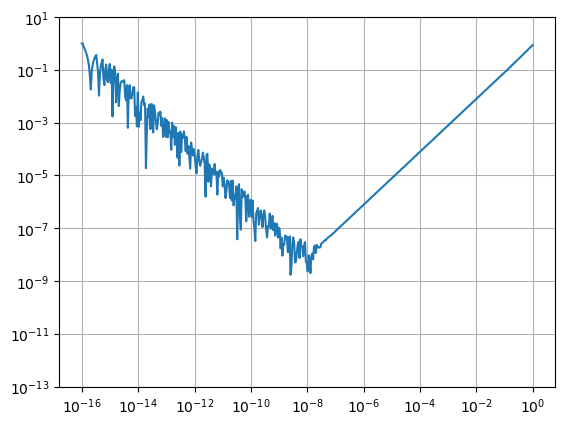

In [5]:
rel_err_FD = np.abs((diff_FD(f, x0, h) - dfdx(x0))/dfdx(x0))
plt.loglog(h, rel_err_FD)

plt.grid()
from matplotlib.ticker import LogLocator
plt.ylim([1e-13, 1e1])
plt.gca().xaxis.set_major_locator(LogLocator(base=100., numticks=20))

Porovnejte s výpočtem metodou centrovaných diferencí

In [6]:
# centrovane diference (central differences)
# ukol 2
def diff_CD(f, x, h): return (f(x+h) - f(x-h))/(2*h)

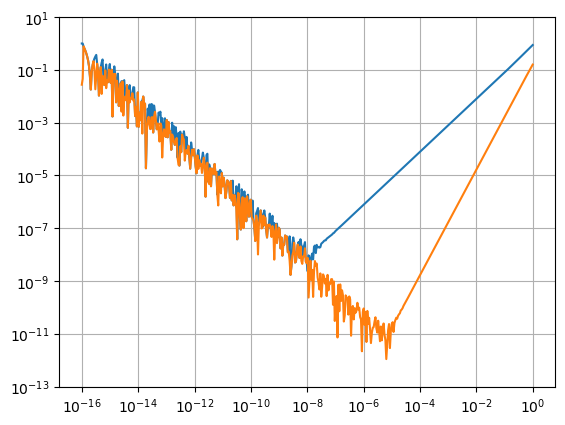

In [7]:
rel_err_CD = np.abs((diff_CD(f, x0, h) - dfdx(x0))/dfdx(x0))
plt.loglog(h, rel_err_FD)
plt.loglog(h, rel_err_CD)

plt.grid()
from matplotlib.ticker import LogLocator
plt.ylim([1e-13, 1e1])
plt.gca().xaxis.set_major_locator(LogLocator(base=100., numticks=20))

## Integrace
Vypočtěte integrál funkce `4/(1+x**2)` na intervalu `[0,1]` obdélníkovou metodou s dělením na 100 intervalů, $n=100$:
$$ s
I^{\rm OP} = \sum_{i=0}^{n-1} f(x_i + \xi h)h
$$
$$
x_i = a + ih;\quad h=\frac{b-a}{n}
$$
Ověřte řád přesnosti metody pro $\xi = 0$ a $\xi = 0.5$.

In [8]:
def quad_rectangle(f, a, b, N, pos=0.5):
    # ukol 3
    dx = (b-a)/N
    x = a + (pos + np.arange(N))*dx
    return np.sum(f(x)*dx)

In [9]:
def f(x): return 4/(1+x**2)

In [14]:
print(quad_rectangle(f, 0, 1, 100, 0) - np.pi)
print(quad_rectangle(f, 0, 1, 100, 0.5) - np.pi)

0.009983333333335676
8.333333331833614e-06


In [10]:
xis = np.linspace(0, 1, 11)
ints = np.array([quad_rectangle(f, 0, 1, 100, xi) for xi in xis])

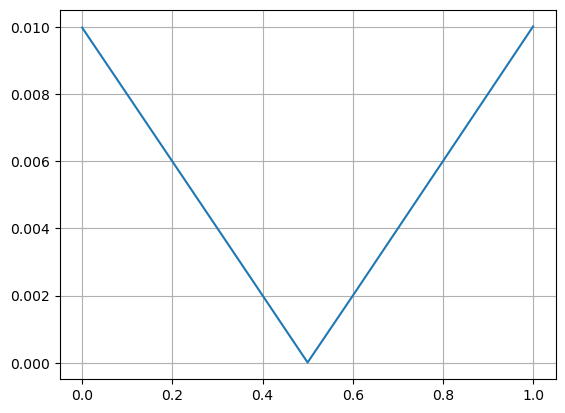

In [11]:
plt.plot(xis, np.abs(ints-np.pi))
plt.grid()

Optimální volba je $\xi=0.5$, dostáváme tak "midpoint rule" druhého řádu přesnosti

### Richardsonova extrapolace
Řekněme, že hledaný integrál $I$ aproximujeme numericky vypočítanou hodnotou $\hat I(h)$ s chybou $E(h)$:
$$\hat I(h)  = I + E(h).$$

Pokud lze chybu metody $E$ vyjádřit jako polynom v závislosti na velikosti integračního kroku
$$
E = A_1h^{p_1} + A_2h^{p_2} + A_3h^{p_3} + \ldots,
$$
můžeme eliminovat dominantní člen rozvoje
$$
\hat I^{(1)} = \frac{2^{p_1} \hat I(h) - \hat I(2h)}{2^{p_1} - 1} = I + A'_2h^{p_2} + A'_3h^{p_3} + \ldots
$$


Vypočtěte integrál z předchozí úlohy lichoběžníkovou metodou s dělením na 10 a 5 intervalů. Využijte tyto aproximace k redukci chyby Richardsonovou metodou. Porovnejte chyby.

In [21]:
def quad_trapezoid(f, a, b, N):
    # ukol 4
    dx = (b-a)/N
    x = a + np.arange(1, N)*dx
    return 0.5*dx*(f(a) + f(b)) + np.sum(f(x)*dx)

In [22]:
N = 10

In [23]:
print(quad_trapezoid(f, 0, 1, N//2)-np.pi)
print(quad_trapezoid(f, 0, 1, N)-np.pi)


-0.006666539778803049
-0.0016666646826335452


In [24]:
def richardson(f, N0, p):
    # ukol 5
    return (2**p * f(N0) - f(N0//2))/(2**p - 1)

In [25]:
def q(N):
    return quad_trapezoid(f, 0, 1, N)
richardson(q, 10, 2) - np.pi

-3.9650577488004046e-08

In [26]:
# alternativne muzeme definovat tzv. lambda funkci inline
richardson(lambda N:quad_trapezoid(f, 0, 1, N), 10, 2) - np.pi

-3.9650577488004046e-08

### Rombergova integrace
Opakovanou aplikací Richardsonovy extrapolace lze postupně eliminovat další členy chybového rozvoje. Pokud použijeme lichoběžníkovou metodu k výpočtu integrálu s dělením na $2^N$ intervalů, můžeme extrapolovat $N$-krát, čímž dostaneme metodou řádu $2(N+1)$.

In [27]:
def romberg(f, a, b, N, debug=False):
    dx = (b-a)
    a = [0.5*dx*(f(a) + f(b))]
    for i in range(1, N):
        dx *= 0.5
        x = (np.arange(0, 2**(i), 2) + 1)*dx
        a.append(a[-1]*0.5 + np.sum(f(x))*dx)

    b = [np.array(a)]
    for j in range(1, N):
        b.append((2**(2*j) * b[-1][1:] - b[-1][:-1])/(2**(2*j) - 1))
    
    if debug:
        for i, l in enumerate(b):
            print("%d. order estimates:"%(2*(i+1)), l-np.pi)
    return b[-1][0]

In [28]:
romberg(f, 0, 1, 5, debug=True)

2. order estimates: [-0.14159265 -0.04159265 -0.01041618 -0.00260416 -0.00065104]
4. order estimates: [-8.25932026e-03 -2.40261388e-05 -1.51131086e-07 -2.36497089e-09]
6. order estimates: [5.24993469e-04 1.44053610e-06 7.55276997e-09]
8. order estimates: [-6.86982792e-06 -1.51929971e-08]
10. order estimates: [1.1687924e-08]


3.141592665277717

In [29]:
N = np.arange(1, 25)
I = np.array([romberg(f, 0, 1, n) for n in N])
I_trapezoid = np.array([quad_trapezoid(f, 0, 1, 2**(n-1)) for n in N])
h = 1/2**(N)

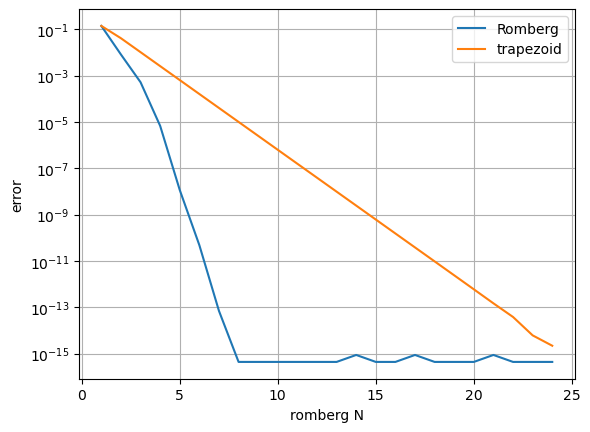

In [30]:
plt.semilogy(N, np.abs(I-np.pi), label="Romberg")
plt.semilogy(N, np.abs(I_trapezoid-np.pi), label="trapezoid")
plt.legend()
plt.ylabel("error")
plt.xlabel("romberg N")
plt.grid()

In [31]:
romberg(f, 0, 1, 9)

3.1415926535897936

In [32]:
np.pi

3.141592653589793

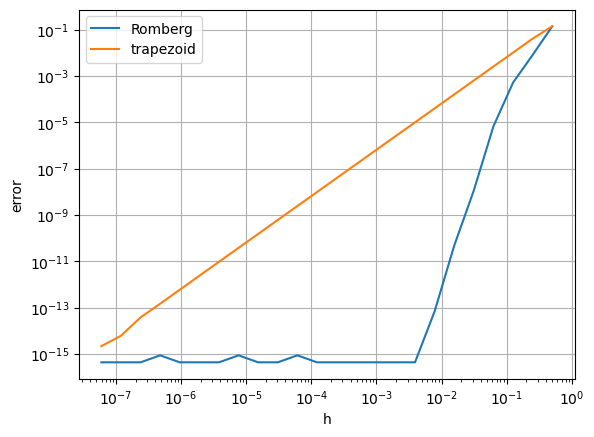

In [33]:
plt.plot(h, np.abs(I-np.pi), label="Romberg")
plt.plot(h, np.abs(I_trapezoid-np.pi), label="trapezoid")
plt.legend()
plt.ylabel("error")
plt.xlabel("h")
plt.grid()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")